In [1]:
print("Hello Major Project SWIN Federated!")

Hello Major Project SWIN Federated!


In [ ]:
# Standard lib
import os
import io
import json
import math
import shutil
from collections import defaultdict
from tqdm import tqdm
import warnings

import time
import json
from datetime import datetime

# Data / I/O
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.enums import Resampling
import tarfile
import threading
import zstandard as zstd

# PyTorch & helpers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from train_utils import BigEarthNetCustomDataset

# ML libs
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, accuracy_score,precision_recall_curve
import numpy as np

# Federated Learning
import flwr as fl

import torch
from train_utils import (
    build_model, build_optimizer, build_scheduler, build_criterion,
    get_client_dataloaders, get_device
)
from client import FLClient

# Model libs
import timm
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

/home/shavak_new/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
HOME_DIR = os.getcwd()
print(HOME_DIR)
label_names = ['Agro-forestry areas', 'Arable land', 'Beaches, dunes, sands', 'Broad-leaved forest', 'Coastal wetlands', 'Complex cultivation patterns', 'Coniferous forest', 'Industrial or commercial units', 'Inland waters', 'Inland wetlands', 'Land principally occupied by agriculture, with significant areas of natural vegetation', 'Marine waters', 'Mixed forest', 'Moors, heathland and sclerophyllous vegetation', 'Natural grassland and sparsely vegetated areas', 'Pastures', 'Permanent crops', 'Transitional woodland, shrub', 'Urban fabric']

/home/shavak_new/victor/mp2


In [4]:
full_df = pd.read_json(HOME_DIR+"/bigearthnet_encoded.json")
print(full_df.head())

                                            patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   

                                             encoded  
0  [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
1  [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...  
2  [0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...  
3  [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...  
4  [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...  


In [5]:
torch.cuda.empty_cache()

In [6]:
def enforce_label_coverage(train_df, val_df, test_df, full_df, label_names):
    """
    Ensure each split has at least ceil(split_size / num_labels) samples per label.
    If not, fetch extra samples from full_df that are not already in train/val/test
    and add them to the split.
    """
    num_labels = len(label_names)

    def top_up_split(split_df, split_name, all_used_ids):
        split_size = len(split_df)
        threshold = math.ceil(split_size / num_labels)

        print(f"{split_name} threshold per label: {threshold}")

        encoded_matrix = np.vstack(split_df["encoded"].values)
        label_counts = encoded_matrix.sum(axis=0)

        for i, count in enumerate(label_counts):
            if count < threshold:
                needed = threshold - int(count)
                label = label_names[i]

                # Find candidates in full dataset that contain this label
                mask = np.array([row[i] == 1 for row in full_df["encoded"].values])
                candidates = full_df[mask]

                # Exclude samples already present in ANY split
                candidates = candidates[~candidates["patch_id"].isin(all_used_ids)]

                if len(candidates) == 0:
                    print(f"⚠️ No available candidates for label '{label}' in {split_name}")
                    continue

                # Sample extra rows
                extra = candidates.sample(n=min(needed, len(candidates)), random_state=42)
                split_df = pd.concat([split_df, extra], ignore_index=True)

                # Update global used IDs so no overlap across splits
                all_used_ids.update(extra["patch_id"])

                print(f"Added {len(extra)} samples of label '{label}' to {split_name}")

        return split_df, all_used_ids

    # Track all used IDs across splits
    all_used_ids = set(train_df["patch_id"]) | set(val_df["patch_id"]) | set(test_df["patch_id"])

    train_df, all_used_ids = top_up_split(train_df, "Train", all_used_ids)
    val_df,   all_used_ids = top_up_split(val_df, "Validation", all_used_ids)
    test_df,  all_used_ids = top_up_split(test_df, "Test", all_used_ids)

    return train_df, val_df, test_df

In [7]:
# ============================================================
# 2. Collate function (skips None safely)
# ============================================================

def safe_collate_fn(batch):
    """Skips None samples (missing or broken patches)."""
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.default_collate(batch)

# ============================================================
# 3. Build ResNet-152 model for 10-band input, 19 classes
# ============================================================
BATCH_SIZE = 16
num_epochs = 100
root_dir = HOME_DIR+"/temp/BigEarthNet-S2"

# ============================================================
# 4. Load and split dataset
# ============================================================
df_loaded = full_df.sample(n=100000, random_state=42)
X = df_loaded["patch_id"].values
y = np.vstack(df_loaded["encoded"].values)

# First split: Train+Val vs Test (15% test)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_val_idx, test_idx = next(msss.split(X, y))
train_val = df_loaded.iloc[train_val_idx]
test_df   = df_loaded.iloc[test_idx]

# Second split: Train vs Val (15% of train_val → ~15% overall)
msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15/0.85, random_state=42)
train_idx, val_idx = next(msss_val.split(train_val["patch_id"].values, np.vstack(train_val["encoded"].values)))
train_df = train_val.iloc[train_idx]
val_df   = train_val.iloc[val_idx]

train_df, val_df, test_df = enforce_label_coverage(train_df, val_df, test_df, full_df, label_names)

total = len(train_df) + len(val_df) + len(test_df)

train_ratio = len(train_df) / total
val_ratio   = len(val_df) / total
test_ratio  = len(test_df) / total

print(f"Train size: {len(train_df)} ({train_ratio:.2%}); "
      f"Val size: {len(val_df)} ({val_ratio:.2%}); "
      f"Test size: {len(test_df)} ({test_ratio:.2%}); "
      f"Total: {total}")

X = train_df["patch_id"].values
y = np.vstack(train_df["encoded"].values)

# Compute pos_weight for each of the 19 labels
label_counts = y.sum(axis=0)
neg_counts = len(y) - label_counts

# Avoid division by zero
pos_weights = np.where(label_counts == 0, 1.0, neg_counts / label_counts)
pos_weights = np.clip(pos_weights, 1.0, 20.0)

print("Pos Weights:", pos_weights)

Train threshold per label: 3685
Added 1052 samples of label 'Beaches, dunes, sands' to Train
Added 1021 samples of label 'Coastal wetlands' to Train
Added 2081 samples of label 'Industrial or commercial units' to Train
Added 612 samples of label 'Inland wetlands' to Train
Added 1703 samples of label 'Moors, heathland and sclerophyllous vegetation' to Train
Added 1910 samples of label 'Natural grassland and sparsely vegetated areas' to Train
Validation threshold per label: 789
⚠️ No available candidates for label 'Beaches, dunes, sands' in Validation
⚠️ No available candidates for label 'Coastal wetlands' in Validation
Added 445 samples of label 'Industrial or commercial units' to Validation
Added 131 samples of label 'Inland wetlands' to Validation
Added 364 samples of label 'Moors, heathland and sclerophyllous vegetation' to Validation
Added 409 samples of label 'Natural grassland and sparsely vegetated areas' to Validation
Test threshold per label: 790
⚠️ No available candidates for 

In [8]:
def split_into_clients(train_df, val_df, num_clients=8, shuffle=True):
    """Split both train_df and val_df into num_clients shards."""
    # --- Split train_df ---
    train_indices = np.arange(len(train_df))
    if shuffle:
        np.random.shuffle(train_indices)
    train_shards = np.array_split(train_indices, num_clients)
    client_train_dfs = [train_df.iloc[shard].reset_index(drop=True) for shard in train_shards]

    # --- Split val_df ---
    val_indices = np.arange(len(val_df))
    if shuffle:
        np.random.shuffle(val_indices)
    val_shards = np.array_split(val_indices, num_clients)
    client_val_dfs = [val_df.iloc[shard].reset_index(drop=True) for shard in val_shards]

    # Pair train/val shards per client
    client_splits = list(zip(client_train_dfs, client_val_dfs))
    return client_splits

# Example usage
client_splits = split_into_clients(train_df, val_df, num_clients=8)


In [9]:
# ============================================================
# 6. Evaluation functions
# ============================================================

def evaluate_model(model, dataloader, criterion, device, thresholds=0.2):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            if batch is None:
                continue
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Stack all predictions and ground truth
    y_true = np.vstack(all_labels)
    y_pred = np.vstack(all_preds)
    
    y_pred_bin = (y_pred >= thresholds).astype(int)

    # --- Classic multi-label metrics ---
    f1_micro = f1_score(y_true, y_pred_bin, average="micro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred_bin, average="macro", zero_division=0)
    precision_micro = precision_score(y_true, y_pred_bin, average="micro", zero_division=0)
    recall_micro = recall_score(y_true, y_pred_bin, average="micro", zero_division=0)

    # --- Average Precision metrics ---
    try:
        ap_micro = average_precision_score(y_true, y_pred, average="micro")
        ap_macro = average_precision_score(y_true, y_pred, average="macro")
    except ValueError:
        ap_micro, ap_macro = np.nan, np.nan

    return (
        total_loss / len(dataloader.dataset),  # average loss
        f1_micro, f1_macro,
        precision_micro, recall_micro,
        ap_micro, ap_macro,
        y_true, y_pred,
    )

def compute_auroc(y_true, y_pred):
    """Compute per-class and mean AUROC safely."""
    n_classes = y_true.shape[1]
    auroc_per_class = []

    for i in range(n_classes):
        try:
            score = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            score = np.nan  # occurs if only one class (all 0s or all 1s)
        auroc_per_class.append(score)

    mean_auroc = np.nanmean(auroc_per_class)
    return mean_auroc, auroc_per_class

def plot_confusion_per_class(y_true, y_pred_bin, label_names):
    """
    Plot a separate confusion matrix for each class (multi-label setup).
    """
    n_classes = len(label_names)

    for i, label in enumerate(label_names):
        cm = confusion_matrix(y_true[:, i], y_pred_bin[:, i])

        # handle single-class case gracefully
        if cm.shape == (1, 1):
            cm = np.array([[cm[0, 0], 0], [0, 0]])

        plt.figure(figsize=(4, 4))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            square=True,
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1']
        )
        plt.title(f"Confusion Matrix — {label}", fontsize=12, fontweight='bold')
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
        
def compute_per_class_metrics(y_true, y_pred_bin, label_names, max_label_len=12):
    """
    Compute precision, recall, F1, and accuracy per class.
    Long labels are truncated with ellipsis for readability.
    """
    rows = []
    for i, label in enumerate(label_names):
        y_true_i = y_true[:, i]
        y_pred_i = y_pred_bin[:, i]

        prec = precision_score(y_true_i, y_pred_i, zero_division=0)
        rec = recall_score(y_true_i, y_pred_i, zero_division=0)
        f1 = f1_score(y_true_i, y_pred_i, zero_division=0)
        acc = accuracy_score(y_true_i, y_pred_i)

        # truncate long labels
        short_label = (label[:max_label_len] + "…") if len(label) > max_label_len else label

        rows.append({
            "Class": short_label,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "Accuracy": acc
        })

    df = pd.DataFrame(rows)
    return df

In [10]:
logging.getLogger("flwr").setLevel(logging.ERROR)

def run_client(cid, c_train, c_val):
    client = FLClient(
        client_id=cid,
        train_df=c_train,
        val_df=c_val,
        root_dir=root_dir,
        pos_weights=pos_weights
    )
    fl.client.start_numpy_client(
        server_address="0.0.0.0:8080",
        client=client
    )

# Launch all clients in parallel using threads
threads = []
for cid, (c_train, c_val) in enumerate(client_splits):
    t = threading.Thread(target=run_client, args=(cid, c_train, c_val))
    t.start()
    # print(f"Thread started for client {cid} (thread id: {t.ident})")
    threads.append(t)

# Wait for all threads to finish
for t in threads:
    t.join()

/home/shavak_new/anaconda3/envs/py311/lib/python3.11/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



🌍 Epoch 1/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1767270302.600500 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270302.748831 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



🌍 Epoch 1/5


I0000 00:00:1767270307.910347 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270308.108863 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



🌍 Epoch 1/5



🌍 Epoch 1/5




I0000 00:00:1767270308.354991 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270308.543082 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270308.704880 3281798 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270308.892173 3281798 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
/home/shavak_new/anaconda3/envs/py311/lib/python3.11/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Training:   0%|          | 1/2450 [00:09<6:13:31,  9.15s/it]


Training:   0%|          | 3/2450 [00:09<1:36:07,  2.36s/it]




Training:   0%|          | 4/2450 [00:14<1:05:00,  1.59s/it]

Training:   0%|          | 5/2450 [00:15<1:50:05,  2.70s/it]




🌍 Epoch 1/5





I0000 00:00:1767270318.049939 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270318.380173 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



🌍 Epoch 1/5






I0000 00:00:1767270318.728577 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270319.001807 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



🌍 Epoch 1/5







I0000 00:00:1767270319.322669 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270319.541524 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



🌍 Epoch 1/5








I0000 00:00:1767270319.813933 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270320.073730 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



Training:   0%|          | 6/2450 [00:18<1:54:24,  2.81s/it]


Training:   0%|          | 7/2450 [00:18<1:22:48,  2.03s/it]




















Training:   0%|          | 9/2450 [00:19<50:39,  1.25s/it]  

















Training:   0%|          | 11/2450 [00:20<34:56,  1.16it/s]














Training:   0%|          | 12/2450 [00:21<31:22,  1.29it/s]





Training:   1%|          | 13/2450 [00:21<26:59,  1.51it/s]

















Training:   1%|          | 14/2450 [00:22<26:34,  1.53it/s]


Training:   1%|          | 15/2450 [00:22<23:19,  1.74it/s]























Training:   1%|          | 17/2450 [00:23<21:53,  1.85it/s]





















Training:   1%|          | 18/2450 [00:24<22:21,  1.81it/s]

Training: 

[Client 3] Finished training, loss=0.7339447597738389



I0000 00:00:1767271694.575051 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767271695.040837 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Training:  99%|█████████▊| 2416/2450 [23:12<00:27,  1.26it/s]

Training:  99%|█████████▊| 2417/2450 [23:12<00:20,  1.65it/s]

Training:  99%|█████████▊| 2418/2450 [23:13<00:15,  2.09it/s]

I0000 00:00:1767270308.543082 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767270308.704880 3281798 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  99%|█████████▊| 2419/2450 [23:13<00:11,  2.67it/s]

Training:  99%|█████████▉| 2420/2450 [23:13<00:09,  3.19it/s]

[Client 4] Finished training, loss=0.7697148931940084




I0000 00:00:1767271696.077158 3281798 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767271696.327912 3281798 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  99%|█████████▉| 2421/2450 [23:14<00:12,  2.29it/s]


Training:  99%|█████████▉| 2424/2450 [23:14<00:06,  3.87it/s]


Training:  99%|█████████▉| 2426/2450 [23:15<00:05,  4.49it/s]






















Training:  99%|█████████▉| 2427/2450 [23:15<00:07,  2.88it/s]







Training:  99%|█████████▉| 2428/2450 [23:15<00:07,  3.08it/s]
















































Training:  99%|█████████▉| 2429/2450 [23:17<00:11,  1.81it/s]




Training:  99%|█████████▉| 2430/2450 [23:17<00:08,  2.27it/s]































































Training:  99%|█████████▉| 2432/2450 [23:18<00:09,  1.82it/s]












Training:  99%|█████████▉| 2433/2450 [23:19<00:08,  1.95it/s]


Training:  99%|███████

[Client 2] Finished training, loss=0.8551774122256602


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767271715.473153 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767271715.721637 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers




















Evaluating:   0%|          | 1/511 [00:01<11:36,  1.36s/it]















Evaluating:   0%|          | 2/511 [00:01<06:53,  1.23it/s]


















































Evaluating:   1%|          | 4/511 [00:03<05:18,  1.59it/s]






















































Evaluating:   1%|          | 5/511 [00:04<06:44,  1.25it/s]






Evaluating:   1%|          | 6/511 [00:04<05:01,  1.68it/s]





























Evaluating:   1%|▏         | 7/511 [00:04<05:10,  1.62it/s]





Evaluating:   2%|▏         | 8/511 [00:05<03:54,  2.14it/s]





Evaluating:   2%|▏         | 9/511 [00:05<03:05,  2.70it/s]




Evaluating:   2%|▏       

[Client 5] Finished training, loss=0.7963971707307267


I0000 00:00:1767271725.105139 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767271725.337239 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers

Evaluating:   4%|▎         | 19/511 [00:10<05:45,  1.42it/s]


Evaluating:   4%|▍         | 20/511 [00:10<04:23,  1.86it/s]













Evaluating:   4%|▍         | 21/511 [00:11<03:48,  2.14it/s]






















Evaluating:   4%|▍         | 22/511 [00:11<03:31,  2.31it/s]

















Evaluating:   5%|▍         | 23/511 [00:11<03:31,  2.31it/s]























Evaluating:   5%|▍         | 24/511 [00:12<03:29,  2.32it/s]
















Evaluating:   5%|▍         | 25/511 [00:12<03:29,  2.32it/s]























































Evaluating:   5%|▌         | 26/511 [00:14<06:01,  1.34it/s]
















Evaluating:   5%|▌         | 28/511 [00:14<04:11,  1.92it/s]



Evaluating:   6%|▌         

[Client 0] Finished training, loss=0.73917455948129





I0000 00:00:1767271907.742773 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767271907.982314 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Evaluating:  56%|█████▋    | 288/511 [03:13<02:57,  1.26it/s]





Evaluating:  57%|█████▋    | 289/511 [03:13<02:24,  1.54it/s]


Evaluating:  57%|█████▋    | 290/511 [03:13<01:55,  1.92it/s]






























Evaluating:  57%|█████▋    | 292/511 [03:14<01:48,  2.03it/s]
















Evaluating:  57%|█████▋    | 293/511 [03:14<01:50,  1.96it/s]





Evaluating:  58%|█████▊    | 294/511 [03:15<01:42,  2.11it/s]







Evaluating:  58%|█████▊    | 295/511 [03:15<01:39,  2.16it/s]




























Evaluating:  58%|█████▊    | 296/511 [03:16<02:09,  1.66it/s]









































Evaluating:  58%|█████▊    | 298/511 [03:17<02:07,  1.67it/s]









Evaluating:  59%|█████▊    | 299/511 [

[Client 3] Finished validation, loss=0.592929377259015












Evaluating:  96%|█████████▋| 493/511 [05:34<00:30,  1.68s/it]








Evaluating:  97%|█████████▋| 494/511 [05:34<00:20,  1.23s/it]



























[Client 4] Finished validation, loss=0.7168816661846398


Evaluating:  97%|█████████▋| 495/511 [05:35<00:17,  1.11s/it]
























Evaluating:  97%|█████████▋| 497/511 [05:36<00:10,  1.34it/s]





[Client 3] Log stored on chain in block 1

🌍 Epoch 2/5



I0000 00:00:1767272051.924089 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767272052.199479 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
ERROR :     Client raised an exception.
Traceback (most recent call last):
  File "/home/shavak_new/anaconda3/envs/py311/lib/python3.11/site-packages/flwr/compat/client/app.py", line 467, in start_client_internal
    reply_message = client_app(message=message, context=context)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shavak_new/anaconda3/envs/py311/lib/python3.11/site-packages/flwr/clientapp/client_app.py", line 143, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shavak_new/anaconda3/envs/py311/lib/python3.11/site-packages/flwr/clientapp/client_app.py", line 127, in ffn
    out_message = handle_legacy_message_from_msgtype(
               

[Client 2] Finished validation, loss=0.618630562450359
[Client 2] Log stored on chain in block 3

🌍 Epoch 2/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767272058.856202 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767272059.095157 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers






















Training:   0%|          | 1/2450 [00:01<47:18,  1.16s/it]









Training:   0%|          | 2/2450 [00:01<27:55,  1.46it/s]





Training:   0%|          | 4/2450 [00:02<15:58,  2.55it/s]












Training:   0%|          | 5/2450 [00:02<14:54,  2.73it/s]








Training:   0%|          | 6/2450 [00:02<14:05,  2.89it/s]



Training:   0%|          | 7/2450 [00:02<12:22,  3.29it/s]




Training:   0%|          | 8/2450 [00:03<12:24,  3.28it/s]

















[Client 5] Finished validation, loss=0.6469127849905237
[Client 5] Log stored on chain in block 4

🌍 Epoch 2/5


I0000 00:00:1767272062.493161 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767272062.706770 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:   0%|          | 9/2450 [00:04<20:18,  2.00it/s]



Training:   0%|          | 10/2450 [00:04<17:42,  2.30it/s]











Training:   0%|          | 11/2450 [00:04<16:10,  2.51it/s]




Training:   0%|          | 12/2450 [00:04<14:19,  2.84it/s]











Training:   1%|          | 13/2450 [00:05<14:36,  2.78it/s]



Training:   1%|          | 16/2450 [00:05<10:30,  3.86it/s]



Training:   1%|          | 19/2450 [00:06<08:45,  4.63it/s]





Training:   1%|          | 20/2450 [00:06<09:08,  4.43it/s]




Training:   1%|          | 21/2450 [00:07<09:43,  4.16it/s]



Training:   1%|          | 22/2450 [00:07<10:25,  3.88it/s]



Training:   1%|          | 23/2450 [00:07<10:09,  3.98it/s]



Training:   1%|          | 24/24

[Client 0] Finished validation, loss=0.5511820565482253
[Client 0] Log stored on chain in block 5

🌍 Epoch 2/5




I0000 00:00:1767272133.540518 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767272133.768970 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers






Training:  11%|█         | 263/2450 [01:16<09:25,  3.87it/s]


Training:  11%|█         | 268/2450 [01:17<07:32,  4.82it/s]

Training:  11%|█         | 269/2450 [01:17<08:30,  4.27it/s]


Training:  11%|█▏        | 280/2450 [01:19<07:13,  5.00it/s]







Training:  12%|█▏        | 285/2450 [01:20<07:42,  4.69it/s]


Training:  12%|█▏        | 292/2450 [01:22<06:33,  5.49it/s]

Training:  12%|█▏        | 296/2450 [01:23<07:33,  4.75it/s]


Training:  13%|█▎        | 308/2450 [01:25<06:45,  5.29it/s]







Training:  13%|█▎        | 309/2450 [01:25<08:14,  4.33it/s]





Training:  13%|█▎        | 313/2450 [01:26<07:41,  4.63it/s]

Training:  13%|█▎        | 316/2450 [01:27<08:01,  4.43it/s]

Training:  13%|█▎        | 317/245

[Client 3] Finished training, loss=0.5956437612160187



I0000 00:00:1767272549.266208 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767272549.486597 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  83%|████████▎ | 2030/2450 [08:11<02:33,  2.74it/s]


Training:  83%|████████▎ | 2031/2450 [08:11<02:22,  2.94it/s]

Training:  83%|████████▎ | 2032/2450 [08:11<02:05,  3.33it/s]



Training:  83%|████████▎ | 2033/2450 [08:12<02:02,  3.39it/s]








Training:  83%|████████▎ | 2035/2450 [08:12<01:59,  3.47it/s]

Training:  83%|████████▎ | 2036/2450 [08:12<01:49,  3.79it/s]







Training:  83%|████████▎ | 2037/2450 [08:13<01:55,  3.57it/s]

Training:  83%|████████▎ | 2038/2450 [08:13<01:53,  3.63it/s]

Training:  83%|████████▎ | 2040/2450 [08:13<01:42,  4.02it/s]












Training:  83%|████████▎ | 2042/2450 [08:14<01:51,  3.66it/s]



Training:  83%|████████▎ | 2043/2450 [08:14<01:57,  3.46it/s]

Training:  83%|██████

[Client 3] Finished validation, loss=0.592929377259015
[Client 3] Log stored on chain in block 6

🌍 Epoch 3/5



I0000 00:00:1767272609.456966 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767272609.640405 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  92%|█████████▏| 2249/2450 [09:11<01:00,  3.34it/s]


Training:  92%|█████████▏| 2252/2450 [09:12<00:49,  3.97it/s]

Training:  92%|█████████▏| 2253/2450 [09:12<00:50,  3.92it/s]












Training:  92%|█████████▏| 2258/2450 [09:13<00:44,  4.30it/s]

Training:  92%|█████████▏| 2259/2450 [09:13<00:44,  4.31it/s]


Training:  92%|█████████▏| 2260/2450 [09:14<00:47,  4.02it/s]

Training:  92%|█████████▏| 2261/2450 [09:14<00:46,  4.06it/s]


Training:  92%|█████████▏| 2262/2450 [09:14<00:50,  3.71it/s]

Training:  92%|█████████▏| 2266/2450 [09:15<00:41,  4.43it/s]



Training:  93%|█████████▎| 2270/2450 [09:16<00:39,  4.56it/s]

Training:  93%|█████████▎| 2271/2450 [09:16<00:40,  4.43it/s]


Training:  93%|█████████▎| 2277/2

[Client 2] Finished training, loss=0.6348625815046091


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767272656.799811 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767272657.025171 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Evaluating:   0%|          | 1/511 [00:00<05:50,  1.46it/s]

Evaluating:   1%|          | 4/511 [00:01<01:40,  5.03it/s]

Evaluating:   2%|▏         | 11/511 [00:01<00:56,  8.83it/s]


Evaluating:   4%|▎         | 18/511 [00:02<00:46, 10.65it/s]

















Evaluating:   5%|▍         | 25/511 [00:03<00:55,  8.75it/s]


Evaluating:   6%|▋         | 33/511 [00:04<00:45, 10.46it/s]


Evaluating:   7%|▋         | 37/511 [00:04<00:47, 10.01it/s]







Evaluating:   8%|▊         | 43/511 [00:05<00:48,  9.75it/s]


Evaluating:   9%|▉         | 45/511 [00:05<00:51,  8.97it/s]




Evaluating:   9%|▉         | 47/511 [00:05<00:56,  8.25it/s]


Evaluating:  10%|█         | 52/511 [00:06<

[Client 2] Finished validation, loss=0.618630562450359
[Client 2] Log stored on chain in block 7

🌍 Epoch 3/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767272714.903064 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767272715.093967 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers




Training:   0%|          | 3/2450 [00:01<14:33,  2.80it/s]


Training:   0%|          | 4/2450 [00:01<13:07,  3.11it/s]

Training:   0%|          | 5/2450 [00:01<12:14,  3.33it/s]

Training:   0%|          | 8/2450 [00:02<10:45,  3.78it/s]

Training:   0%|          | 10/2450 [00:03<11:17,  3.60it/s]

Training:   0%|          | 11/2450 [00:03<10:57,  3.71it/s]


Training:   1%|          | 13/2450 [00:03<09:55,  4.09it/s]

Training:   1%|          | 16/2450 [00:04<09:20,  4.34it/s]

Training:   1%|          | 17/2450 [00:04<09:21,  4.34it/s]

















Training:   1%|          | 22/2450 [00:06<10:10,  3.98it/s]



Training:   1%|          | 28/2450 [00:07<08:32,  4.72it/s]

Tra

[Client 7] Finished training, loss=0.8094480551193047





I0000 00:00:1767273070.584729 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273070.839570 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  62%|██████▏   | 1525/2450 [05:56<05:35,  2.75it/s]

Training:  62%|██████▏   | 1526/2450 [05:56<05:21,  2.87it/s]



Training:  62%|██████▏   | 1529/2450 [05:57<03:57,  3.88it/s]






Training:  62%|██████▏   | 1531/2450 [05:57<03:41,  4.16it/s]



Training:  63%|██████▎   | 1532/2450 [05:57<03:38,  4.21it/s]






Training:  63%|██████▎   | 1533/2450 [05:58<03:28,  4.40it/s]



Training:  63%|██████▎   | 1534/2450 [05:58<03:23,  4.50it/s]





Training:  63%|██████▎   | 1539/2450 [05:59<02:47,  5.42it/s]






Training:  63%|██████▎   | 1540/2450 [05:59<03:11,  4.75it/s]



Training:  63%|██████▎   | 1541/2450 [05:59<03:22,  4.49it/s]












Training:  63%|██████▎   | 1542/2450 [06:00<04:06,  3.69it/s]




Trainin

[Client 3] Finished training, loss=0.5746825434916092



I0000 00:00:1767273112.681908 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273112.935618 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



Training:  69%|██████▊   | 1684/2450 [06:38<04:59,  2.56it/s]






Training:  69%|██████▉   | 1685/2450 [06:38<04:38,  2.75it/s]






Training:  69%|██████▉   | 1686/2450 [06:39<04:32,  2.80it/s]











Training:  69%|██████▉   | 1687/2450 [06:39<04:44,  2.68it/s]









Training:  69%|██████▉   | 1688/2450 [06:39<04:38,  2.73it/s]














Training:  69%|██████▉   | 1689/2450 [06:40<04:34,  2.77it/s]














Training:  69%|██████▉   | 1690/2450 [06:40<04:59,  2.54it/s]








Training:  69%|██████▉   | 1691/2450 [06:40<04:45,  2.66it/s]









Training:  69%|██████▉   | 1692/2450 [06:41<04:29,  2.81it/s]








Training:  69%|██████▉   | 1693/2450 [06:41<04:31,  2.79it/s]




Training:  69%|██████▉   | 1694

[Client 3] Finished validation, loss=0.524844404959541
[Client 3] Log stored on chain in block 8

🌍 Epoch 4/5



I0000 00:00:1767273185.742664 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273185.964905 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



Training:  78%|███████▊  | 1909/2450 [07:51<03:48,  2.36it/s]








Training:  78%|███████▊  | 1910/2450 [07:51<03:46,  2.38it/s]






Training:  78%|███████▊  | 1911/2450 [07:52<03:34,  2.52it/s]



Training:  78%|███████▊  | 1912/2450 [07:52<03:14,  2.77it/s]



Training:  78%|███████▊  | 1913/2450 [07:52<02:48,  3.19it/s]



Training:  78%|███████▊  | 1914/2450 [07:52<02:33,  3.49it/s]



Training:  78%|███████▊  | 1915/2450 [07:53<02:22,  3.76it/s]



Training:  78%|███████▊  | 1916/2450 [07:53<02:13,  4.01it/s]




Training:  78%|███████▊  | 1917/2450 [07:53<02:19,  3.82it/s]









Training:  78%|███████▊  | 1918/2450 [07:53<02:42,  3.28it/s]



Training:  78%|███████▊  | 1920/2450 [07:54<02:16,  3.88it/s]









Trai

[Client 7] Finished validation, loss=0.5956781585096204
[Client 7] Log stored on chain in block 9

🌍 Epoch 2/5





I0000 00:00:1767273197.740246 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273197.976394 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers

Training:  79%|███████▉  | 1943/2450 [08:03<03:45,  2.25it/s]

Training:  79%|███████▉  | 1944/2450 [08:03<03:21,  2.51it/s]

Training:  80%|███████▉  | 1952/2450 [08:05<01:45,  4.71it/s]

Training:  80%|███████▉  | 1953/2450 [08:05<01:48,  4.57it/s]


Training:  80%|███████▉  | 1954/2450 [08:06<02:01,  4.10it/s]

Training:  80%|███████▉  | 1956/2450 [08:06<02:01,  4.06it/s]

Training:  80%|████████  | 1961/2450 [08:07<01:46,  4.61it/s]

Training:  80%|████████  | 1962/2450 [08:07<01:51,  4.38it/s]


Training:  80%|████████  | 1968/2450 [08:09<01:32,  5.21it/s]


Training:  80%|████████  | 1969/2450 [08:09<01:48,  4.43it/s]

Training:  80%|████████  | 1971/2450 [08:09<01:49,  4.37it/s]

Training:  80%|████████  | 1972/2450 [08:10<

[Client 2] Finished training, loss=0.5980736309015601


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767273317.518110 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273317.758698 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers













Evaluating:   0%|          | 1/511 [00:00<08:18,  1.02it/s]



Evaluating:   1%|          | 3/511 [00:01<03:14,  2.61it/s]

Evaluating:   2%|▏         | 8/511 [00:01<01:25,  5.91it/s]





Evaluating:   2%|▏         | 11/511 [00:02<01:19,  6.32it/s]

Evaluating:   2%|▏         | 12/511 [00:02<01:12,  6.91it/s]


[Client 5] Finished training, loss=0.6603489433524438


I0000 00:00:1767273320.121818 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273320.336897 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Evaluating:   3%|▎         | 15/511 [00:03<01:40,  4.92it/s]








Evaluating:   3%|▎         | 17/511 [00:03<01:29,  5.52it/s]





Evaluating:   4%|▎         | 19/511 [00:03<01:21,  6.04it/s]
















Evaluating:   4%|▍         | 20/511 [00:04<02:36,  3.14it/s]

Evaluating:   4%|▍         | 21/511 [00:04<02:17,  3.57it/s]






Evaluating:   4%|▍         | 22/511 [00:05<02:19,  3.50it/s]



Evaluating:   5%|▍         | 23/511 [00:05<02:08,  3.80it/s]

Evaluating:   5%|▌         | 26/511 [00:05<01:31,  5.30it/s]




Evaluating:   5%|▌         | 27/511 [00:06<01:28,  5.49it/s]


Evaluating:   6%|▌         | 30/511 [00:06<01:08,  7.00it/s]




Evaluating:   6%|▌         | 31/511 [00:06<01:12,  6.65it/s]










Evaluating:

[Client 2] Finished validation, loss=0.5147314849567437
[Client 2] Log stored on chain in block 10

🌍 Epoch 4/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767273403.107788 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273403.341769 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers














Training:   0%|          | 2/2450 [00:01<25:19,  1.61it/s]










Training:   0%|          | 3/2450 [00:01<22:46,  1.79it/s]



Training:   0%|          | 4/2450 [00:02<21:07,  1.93it/s]





Training:   0%|          | 6/2450 [00:02<16:21,  2.49it/s]


Training:   0%|          | 9/2450 [00:03<11:51,  3.43it/s]


Training:   0%|          | 11/2450 [00:04<11:14,  3.61it/s]


Training:   0%|          | 12/2450 [00:04<11:29,  3.53it/s]



Training:   1%|          | 14/2450 [00:04<09:48,  4.14it/s]


[Client 5] Finished validation, loss=0.6469127849905237
[Client 5] Log stored on chain in block 11

🌍 Epoch 3/5


I0000 00:00:1767273408.528140 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273408.800075 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:   1%|          | 15/2450 [00:05<18:24,  2.20it/s]


Training:   1%|          | 16/2450 [00:06<15:35,  2.60it/s]

Training:   1%|          | 18/2450 [00:06<13:11,  3.07it/s]

Training:   1%|          | 19/2450 [00:06<12:21,  3.28it/s]









Training:   1%|          | 20/2450 [00:07<14:07,  2.87it/s]

Training:   1%|▏         | 31/2450 [00:09<07:36,  5.30it/s]


Training:   1%|▏         | 35/2450 [00:10<08:06,  4.96it/s]

Training:   1%|▏         | 36/2450 [00:10<08:36,  4.67it/s]





Training:   2%|▏         | 40/2450 [00:11<08:37,  4.65it/s]

Training:   2%|▏         | 44/2450 [00:12<08:51,  4.53it/s]



Training:   2%|▏         | 47/2450 [00:13<09:13,  4.34it/s]


Training:   2%|▏         | 60/2450 [00:15<07:42,  5.17it

[Client 3] Finished training, loss=0.5240414261693236



I0000 00:00:1767273707.195746 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273707.435118 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



Training:  53%|█████▎    | 1294/2450 [05:04<06:19,  3.05it/s]



Training:  53%|█████▎    | 1296/2450 [05:05<05:20,  3.60it/s]










Training:  53%|█████▎    | 1297/2450 [05:05<05:50,  3.29it/s]

Training:  53%|█████▎    | 1298/2450 [05:06<05:38,  3.40it/s]



Training:  53%|█████▎    | 1301/2450 [05:06<04:53,  3.92it/s]
















Training:  53%|█████▎    | 1303/2450 [05:07<05:35,  3.42it/s]

Training:  53%|█████▎    | 1304/2450 [05:07<05:17,  3.61it/s]


Training:  53%|█████▎    | 1305/2450 [05:08<05:26,  3.51it/s]

Training:  53%|█████▎    | 1306/2450 [05:08<05:11,  3.68it/s]






Training:  53%|█████▎    | 1308/2450 [05:08<05:08,  3.71it/s]

Training:  53%|█████▎    | 1309/2450 [05:09<04:54,  3.88it/s]





Training:

[Client 3] Finished validation, loss=0.524844404959541
[Client 3] Log stored on chain in block 12

🌍 Epoch 5/5



I0000 00:00:1767273765.758123 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273766.010111 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  61%|██████▏   | 1505/2450 [06:03<06:09,  2.56it/s]





Training:  62%|██████▏   | 1507/2450 [06:03<05:14,  3.00it/s]

Training:  62%|██████▏   | 1509/2450 [06:04<04:40,  3.35it/s]

Training:  62%|██████▏   | 1516/2450 [06:05<03:03,  5.09it/s]

Training:  62%|██████▏   | 1517/2450 [06:06<03:15,  4.78it/s]





Training:  62%|██████▏   | 1529/2450 [06:08<02:54,  5.28it/s]


Training:  62%|██████▏   | 1531/2450 [06:09<03:03,  5.02it/s]

Training:  63%|██████▎   | 1532/2450 [06:09<03:24,  4.49it/s]


Training:  63%|██████▎   | 1536/2450 [06:10<03:11,  4.77it/s]

Training:  63%|██████▎   | 1538/2450 [06:10<03:31,  4.31it/s]

Training:  63%|██████▎   | 1539/2450 [06:10<03:39,  4.15it/s]


Training:  63%|██████▎   | 1543/2450 [0

[Client 2] Finished training, loss=0.5171031725839736


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767273986.227025 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767273986.487526 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers





Evaluating:   1%|          | 5/511 [00:01<01:32,  5.44it/s]

Evaluating:   2%|▏         | 10/511 [00:01<00:58,  8.54it/s]

Evaluating:   3%|▎         | 17/511 [00:02<00:46, 10.60it/s]















Evaluating:   4%|▎         | 19/511 [00:02<01:06,  7.44it/s]

Evaluating:   5%|▌         | 27/511 [00:03<00:47, 10.15it/s]


Evaluating:   6%|▌         | 29/511 [00:03<00:47, 10.22it/s]






Evaluating:   7%|▋         | 35/511 [00:04<00:47, 10.08it/s]


Evaluating:   7%|▋         | 37/511 [00:04<00:49,  9.49it/s]


Evaluating:   9%|▉         | 48/511 [00:05<00:40, 11.33it/s]


Evaluating:  10%|▉         | 50/511 [00:05<00:45, 10.13it/s]



Evaluating:  11%|█         | 56/511 [00:06<0

[Client 2] Finished validation, loss=0.5147314849567437
[Client 2] Log stored on chain in block 13

🌍 Epoch 5/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767274044.988702 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767274045.229851 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



Training:   0%|          | 3/2450 [00:01<16:01,  2.54it/s]

Training:   0%|          | 4/2450 [00:01<13:14,  3.08it/s]


Training:   0%|          | 8/2450 [00:02<10:06,  4.03it/s]

Training:   0%|          | 9/2450 [00:02<10:24,  3.91it/s]









Training:   0%|          | 10/2450 [00:03<12:08,  3.35it/s]

Training:   0%|          | 11/2450 [00:03<11:16,  3.60it/s]

Training:   1%|          | 16/2450 [00:04<09:09,  4.43it/s]


Training:   1%|          | 20/2450 [00:05<08:01,  5.04it/s]

Training:   1%|          | 22/2450 [00:06<09:37,  4.21it/s]

Training:   1%|          | 23/2450 [00:06<09:32,  4.24it/s]


Training:   1%|          | 24/2450 [00:06<10:38,  3.80it/s]

Training:   1

[Client 3] Finished training, loss=0.5180104419061367



I0000 00:00:1767274254.251384 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767274254.465604 3281796 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  37%|███▋      | 904/2450 [03:29<09:02,  2.85it/s]


Training:  37%|███▋      | 905/2450 [03:30<08:28,  3.04it/s]

Training:  37%|███▋      | 906/2450 [03:30<07:32,  3.41it/s]





Training:  37%|███▋      | 907/2450 [03:30<07:43,  3.33it/s]


Training:  37%|███▋      | 909/2450 [03:31<06:42,  3.83it/s]






Training:  37%|███▋      | 910/2450 [03:31<07:06,  3.61it/s]

Training:  37%|███▋      | 912/2450 [03:31<06:36,  3.88it/s]






Training:  37%|███▋      | 913/2450 [03:32<07:07,  3.59it/s]

Training:  37%|███▋      | 915/2450 [03:32<06:41,  3.82it/s]

Training:  37%|███▋      | 916/2450 [03:32<06:33,  3.90it/s]


Training:  37%|███▋      | 918/2450 [03:33<06:17,  4.06it/s]










Training:  38%|███▊      | 920/2450

[Client 3] Finished validation, loss=0.4865845722467002
[Client 3] Log stored on chain in block 14


Training:  46%|████▌     | 1120/2450 [04:31<20:56,  1.06it/s]

Training:  46%|████▌     | 1121/2450 [04:32<16:09,  1.37it/s]


Training:  46%|████▌     | 1124/2450 [04:32<07:54,  2.80it/s]

Training:  46%|████▌     | 1126/2450 [04:32<05:38,  3.91it/s]

Training:  46%|████▌     | 1131/2450 [04:33<03:57,  5.56it/s]




Training:  46%|████▌     | 1132/2450 [04:33<04:07,  5.32it/s]

Training:  46%|████▋     | 1135/2450 [04:34<03:42,  5.91it/s]

Training:  46%|████▋     | 1139/2450 [04:35<03:51,  5.66it/s]

Training:  47%|████▋     | 1141/2450 [04:35<03:38,  5.99it/s]

Training:  47%|████▋     | 1144/2450 [04:36<03:43,  5.84it/s]




Training:  47%|████▋     | 1146/2450 [04:36<04:00,  5.41it/s]

Training:  47%|████▋     | 1149/2450 [04:37<03:52,  5.60it/s]








Training:  47%|████▋     | 1152/2450 [04:37<04:12,  5.15it/s]

Training:  47%|████▋     | 1154/2450 [04:37<03:51,  5.59it/s]

Training:  47%|████▋     | 1157/2450 [04:38<03:29,  6.17it/s]




Training:  47%|████▋     | 1158/2450 [

[Client 5] Finished training, loss=0.5863947027645825


I0000 00:00:1767274474.581609 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767274474.825930 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Training:  79%|███████▉  | 1944/2450 [07:10<02:50,  2.97it/s]

Training:  79%|███████▉  | 1945/2450 [07:10<02:30,  3.36it/s]

Training:  79%|███████▉  | 1946/2450 [07:10<02:19,  3.61it/s]




Training:  80%|███████▉  | 1948/2450 [07:10<01:49,  4.57it/s]




Training:  80%|███████▉  | 1949/2450 [07:11<01:48,  4.64it/s]

Training:  80%|███████▉  | 1950/2450 [07:11<01:48,  4.61it/s]

Training:  80%|███████▉  | 1951/2450 [07:11<01:52,  4.44it/s]




Training:  80%|███████▉  | 1952/2450 [07:11<01:58,  4.20it/s]





Training:  80%|███████▉  | 1953/2450 [07:12<02:08,  3.86it/s]




Training:  80%|███████▉  | 1955/2450 [07:12<02:04,  3.97it/s]




Training:  80%|███████▉  | 1956/2450 [07:13<02:08,  3.85it/s]

Training:  80%|███████▉  | 195

[Client 0] Finished training, loss=0.5709467199855313



I0000 00:00:1767274529.958980 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767274530.180723 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers






Training:  88%|████████▊ | 2160/2450 [08:05<01:59,  2.43it/s]




Training:  88%|████████▊ | 2161/2450 [08:05<01:47,  2.70it/s]








Training:  88%|████████▊ | 2162/2450 [08:06<01:47,  2.69it/s]















Training:  88%|████████▊ | 2163/2450 [08:06<01:52,  2.55it/s]




Training:  88%|████████▊ | 2164/2450 [08:07<01:45,  2.72it/s]








Training:  88%|████████▊ | 2165/2450 [08:07<01:42,  2.77it/s]

Training:  88%|████████▊ | 2166/2450 [08:07<01:34,  3.01it/s]














Training:  88%|████████▊ | 2167/2450 [08:08<01:37,  2.91it/s]



Training:  88%|████████▊ | 2168/2450 [08:08<01:29,  3.16it/s]







Training:  89%|████████▊ | 2169/2450 [08:08<01:29,  3.14it/s]

Training:  89%|████████▊ | 2170/2450 [08:08<01:22,  

[Client 5] Finished validation, loss=0.5165336304789137
[Client 5] Log stored on chain in block 15

🌍 Epoch 4/5


I0000 00:00:1767274545.340121 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767274545.583841 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers

Training:  90%|█████████ | 2208/2450 [08:20<01:53,  2.13it/s]








Training:  90%|█████████ | 2210/2450 [08:21<01:26,  2.78it/s]







Training:  90%|█████████ | 2214/2450 [08:22<00:51,  4.56it/s]












Training:  90%|█████████ | 2215/2450 [08:22<00:59,  3.98it/s]




Training:  90%|█████████ | 2217/2450 [08:23<00:57,  4.08it/s]








Training:  91%|█████████ | 2218/2450 [08:23<01:03,  3.65it/s]

Training:  91%|█████████ | 2219/2450 [08:23<01:01,  3.77it/s]

Training:  91%|█████████ | 2220/2450 [08:23<00:56,  4.04it/s]



Training:  91%|█████████ | 2221/2450 [08:24<00:58,  3.90it/s]














Training:  91%|█████████ | 2222/2450 [08:24<01:06,  3.43it/s]

Training:  91%|█████████ | 2224/2450 [08:25<01:01,  3.66it/s]




[Client 0] Finished validation, loss=0.5511820565482253
[Client 0] Log stored on chain in block 16

🌍 Epoch 3/5



I0000 00:00:1767274606.172721 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767274606.410075 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training: 100%|██████████| 2450/2450 [09:22<00:00,  4.83it/s]





[Client 2] Finished training, loss=0.5424200510529186


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767274608.043735 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767274608.264483 3281794 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers

Evaluating:   0%|          | 1/511 [00:00<06:10,  1.38it/s]



Evaluating:   1%|          | 3/511 [00:00<02:21,  3.60it/s]



Evaluating:   2%|▏         | 12/511 [00:01<00:51,  9.63it/s]



Evaluating:   3%|▎         | 17/511 [00:02<00:53,  9.22it/s]



Evaluating:   4%|▎         | 19/511 [00:02<00:56,  8.73it/s]



Evaluating:   4%|▍         | 22/511 [00:02<00:50,  9.75it/s]


Evaluating:   5%|▍         | 23/511 [00:03<00:54,  8.90it/s]



Evaluating:   5%|▌         | 27/511 [00:03<00:49,  9.80it/s]



Evaluating:   6%|▋         | 33/511 [00:04<00:46, 10.35it/s]



Evaluating:   7%|▋         | 35/511 [00:04<00:50,  9.43it/s]









Evaluating:   8%|▊         | 41/511 [00:04<00:48,

[Client 2] Finished validation, loss=0.5326446501254335
[Client 2] Log stored on chain in block 17


[Client 6] Finished training, loss=0.7416658143277484


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767275028.132215 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275028.394449 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers






















Evaluating:   1%|          | 4/511 [00:01<03:07,  2.71it/s]



Evaluating:   1%|▏         | 7/511 [00:02<02:22,  3.52it/s]










Evaluating:   2%|▏         | 10/511 [00:03<02:01,  4.14it/s]



Evaluating:   3%|▎         | 13/511 [00:03<01:35,  5.22it/s]









Evaluating:   3%|▎         | 15/511 [00:04<02:03,  4.02it/s]


Evaluating:   3%|▎         | 16/511 [00:04<01:55,  4.29it/s]

Evaluating:   4%|▎         | 19/511 [00:05<01:27,  5.61it/s]









Evaluating:   4%|▍         | 22/511 [00:05<01:26,  5.66it/s]








Evaluating:   5%|▍         | 23/511 [00:06<02:37,  3.09it/s]




















Evaluating:   5%|▌         | 27/511 [00:07<02:10,  3.70it/s

[Client 5] Finished training, loss=0.513109457670444


I0000 00:00:1767275066.807654 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275067.035871 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers

Evaluating:  30%|███       | 155/511 [00:39<01:26,  4.14it/s]


Evaluating:  31%|███       | 156/511 [00:39<01:18,  4.54it/s]



Evaluating:  31%|███       | 157/511 [00:39<01:13,  4.81it/s]






Evaluating:  31%|███       | 158/511 [00:39<01:06,  5.31it/s]


Evaluating:  31%|███▏      | 160/511 [00:40<01:02,  5.61it/s]



Evaluating:  32%|███▏      | 162/511 [00:40<00:52,  6.64it/s]























Evaluating:  32%|███▏      | 164/511 [00:41<01:38,  3.52it/s]


Evaluating:  32%|███▏      | 166/511 [00:41<01:19,  4.33it/s]









Evaluating:  33%|███▎      | 168/511 [00:42<01:10,  4.85it/s]



Evaluating:  33%|███▎      | 170/511 [00:42<01:01,  5.58it/s]













Evaluating:  33%|███▎      | 171/511 [00:42<01:36,  3.54i

[Client 5] Finished validation, loss=0.5165336304789137
[Client 5] Log stored on chain in block 18

🌍 Epoch 5/5


I0000 00:00:1767275127.853971 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275128.106543 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers






Evaluating:  75%|███████▌  | 384/511 [01:40<00:49,  2.56it/s]


Evaluating:  76%|███████▌  | 388/511 [01:40<00:24,  5.11it/s]









Evaluating:  76%|███████▌  | 389/511 [01:41<00:34,  3.53it/s]



Evaluating:  77%|███████▋  | 392/511 [01:42<00:29,  3.98it/s]



Evaluating:  77%|███████▋  | 395/511 [01:42<00:24,  4.71it/s]








Evaluating:  78%|███████▊  | 397/511 [01:42<00:20,  5.56it/s]




Evaluating:  78%|███████▊  | 399/511 [01:43<00:26,  4.18it/s]



Evaluating:  79%|███████▊  | 402/511 [01:44<00:23,  4.67it/s]










Evaluating:  79%|███████▉  | 406/511 [01:45<00:20,  5.23it/s]

Evaluating:  80%|███████▉  | 408/511 [01:45<00:20,  5.12it/s]


Evaluating:  80%|████████  | 410/511 [01:45<00:18,  5.40it/s]




Evaluat

[Client 6] Finished validation, loss=0.5781306526069253
[Client 6] Log stored on chain in block 19

🌍 Epoch 2/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767275156.313415 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275156.558160 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers






































Training:   0%|          | 1/2450 [00:02<1:38:41,  2.42s/it]













Training:   0%|          | 2/2450 [00:03<1:04:24,  1.58s/it]


















Training:   0%|          | 3/2450 [00:05<1:16:10,  1.87s/it]


















Training:   0%|          | 4/2450 [00:07<1:19:15,  1.94s/it]




























Training:   0%|          | 5/2450 [00:10<1:27:04,  2.14s/it]








Training:   0%|          | 6/2450 [00:11<1:11:08,  1.75s/it]















Training:   0%|          | 7/2450 [00:12<1:09:29,  1.71s/it]

















Training:   0%|          | 8/2450 [00:14<1:05:44,  1.62s/it]












Training:   0%|          | 9/2450 [00:1

[Client 0] Finished training, loss=0.5698228870362652



I0000 00:00:1767275223.545880 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275223.793859 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers











Training:   2%|▏         | 45/2450 [01:08<54:35,  1.36s/it]



















Training:   2%|▏         | 46/2450 [01:09<48:54,  1.22s/it]
















Training:   2%|▏         | 47/2450 [01:10<45:13,  1.13s/it]




















Training:   2%|▏         | 48/2450 [01:10<41:57,  1.05s/it]












Training:   2%|▏         | 49/2450 [01:11<38:59,  1.03it/s]


















Training:   2%|▏         | 50/2450 [01:12<38:39,  1.03it/s]









Training:   2%|▏         | 51/2450 [01:13<34:36,  1.16it/s]
















Training:   2%|▏         | 52/2450 [01:14<32:39,  1.22it/s]









Training:   2%|▏         | 53/2450 [01:14<31:39,  1.26it/s]

















Training:   2%|▏         | 54/2450 [01:15<30:16,  1.32it

[Client 0] Finished validation, loss=0.49333914225587183
[Client 0] Log stored on chain in block 20

🌍 Epoch 4/5



I0000 00:00:1767275278.767901 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275279.022042 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



Training:   5%|▍         | 122/2450 [02:03<31:05,  1.25it/s]



















Training:   5%|▌         | 123/2450 [02:04<38:14,  1.01it/s]




















Training:   5%|▌         | 124/2450 [02:05<44:10,  1.14s/it]










Training:   5%|▌         | 125/2450 [02:06<38:51,  1.00s/it]













Training:   5%|▌         | 126/2450 [02:07<41:56,  1.08s/it]
















Training:   5%|▌         | 127/2450 [02:09<49:13,  1.27s/it]









Training:   5%|▌         | 128/2450 [02:10<45:21,  1.17s/it]











Training:   5%|▌         | 129/2450 [02:11<41:28,  1.07s/it]










Training:   5%|▌         | 130/2450 [02:12<43:09,  1.12s/it]













Training:   5%|▌         | 131/2450 [02:14<45:58,  1.19s/it]











[Client 7] Finished training, loss=0.6344961938669225




I0000 00:00:1767275469.793373 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275470.004736 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers








Training:  10%|█         | 254/2450 [05:14<50:08,  1.37s/it]







Training:  10%|█         | 255/2450 [05:14<40:49,  1.12s/it]











Training:  10%|█         | 256/2450 [05:15<35:23,  1.03it/s]













Training:  10%|█         | 257/2450 [05:16<31:22,  1.17it/s]









Training:  11%|█         | 258/2450 [05:16<29:28,  1.24it/s]














Training:  11%|█         | 259/2450 [05:17<28:24,  1.29it/s]














Training:  11%|█         | 260/2450 [05:18<29:07,  1.25it/s]


















Training:  11%|█         | 261/2450 [05:19<30:11,  1.21it/s]






Training:  11%|█         | 262/2450 [05:19<26:33,  1.37it/s]

















Training:  11%|█         | 263/2450 [05:20<26:24,  1.38it/s]









Traini

[Client 7] Finished validation, loss=0.595678158451213
[Client 7] Log stored on chain in block 21

🌍 Epoch 3/5




I0000 00:00:1767275526.061539 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275526.280508 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers

Training:  14%|█▎        | 335/2450 [06:10<29:25,  1.20it/s]



















Training:  14%|█▎        | 336/2450 [06:12<47:18,  1.34s/it]



Training:  14%|█▍        | 337/2450 [06:13<39:34,  1.12s/it]









Training:  14%|█▍        | 338/2450 [06:14<42:37,  1.21s/it]














Training:  14%|█▍        | 339/2450 [06:16<43:09,  1.23s/it]


Training:  14%|█▍        | 340/2450 [06:16<34:52,  1.01it/s]



















Training:  14%|█▍        | 341/2450 [06:19<51:49,  1.47s/it]






Training:  14%|█▍        | 342/2450 [06:20<48:18,  1.37s/it]












Training:  14%|█▍        | 343/2450 [06:21<45:21,  1.29s/it]











Training:  14%|█▍        | 344/2450 [06:23<49:10,  1.40s/it]






























Traini

[Client 5] Finished training, loss=0.5361834673832747


I0000 00:00:1767275633.099708 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275633.328674 3281800 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers








Training:  17%|█▋        | 407/2450 [07:57<42:14,  1.24s/it]





Training:  17%|█▋        | 408/2450 [07:58<34:21,  1.01s/it]





Training:  17%|█▋        | 409/2450 [07:58<29:18,  1.16it/s]












Training:  17%|█▋        | 410/2450 [07:59<27:34,  1.23it/s]














Training:  17%|█▋        | 411/2450 [08:00<27:15,  1.25it/s]






Training:  17%|█▋        | 412/2450 [08:01<27:35,  1.23it/s]








Training:  17%|█▋        | 413/2450 [08:02<27:27,  1.24it/s]









Training:  17%|█▋        | 414/2450 [08:02<24:40,  1.38it/s]






Training:  17%|█▋        | 415/2450 [08:03<24:29,  1.39it/s]



Training:  17%|█▋        | 416/2450 [08:03<22:15,  1.52it/s]


Training:  17%|█▋        | 417/2450 [08:04<18:40,  1.81i

[Client 5] Finished validation, loss=0.4955985035048227
[Client 5] Log stored on chain in block 22





Training:  20%|██        | 491/2450 [08:57<53:31,  1.64s/it]









Training:  20%|██        | 492/2450 [08:57<41:24,  1.27s/it]








Training:  20%|██        | 493/2450 [08:58<34:35,  1.06s/it]





Training:  20%|██        | 494/2450 [08:58<27:59,  1.16it/s]






Training:  20%|██        | 495/2450 [08:59<24:43,  1.32it/s]














Training:  20%|██        | 496/2450 [08:59<22:25,  1.45it/s]









Training:  20%|██        | 497/2450 [09:00<22:05,  1.47it/s]











Training:  20%|██        | 498/2450 [09:01<22:14,  1.46it/s]







Training:  20%|██        | 499/2450 [09:01<20:29,  1.59it/s]









Training:  20%|██        | 500/2450 [09:02<20:38,  1.57it/s]





Training:  20%|██        | 501/2450 [09:02<18:44,  1.73it/s]















Training:  20%|██        | 502/2450 [09:03<19:48,  1.64it/s]









Training:  21%|██        | 503/2450 [09:03<18:02,  1.80it/s]





Training:  21%|██        | 504/2450 [09:04<16:46,  1.93it/s]



Training:  21%|██        | 5

[Client 0] Finished training, loss=0.49414201845624006


I0000 00:00:1767275841.667219 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275841.969274 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  31%|███       | 762/2450 [11:25<15:34,  1.81it/s]

Training:  31%|███       | 763/2450 [11:26<12:51,  2.19it/s]

Training:  31%|███       | 764/2450 [11:26<11:13,  2.50it/s]









Training:  31%|███       | 765/2450 [11:26<10:54,  2.57it/s]







Training:  31%|███▏      | 766/2450 [11:27<10:42,  2.62it/s]

Training:  31%|███▏      | 767/2450 [11:27<09:39,  2.91it/s]









Training:  31%|███▏      | 768/2450 [11:27<10:03,  2.79it/s]







Training:  31%|███▏      | 769/2450 [11:28<09:51,  2.84it/s]

Training:  31%|███▏      | 770/2450 [11:28<09:50,  2.84it/s]









Training:  31%|███▏      | 771/2450 [11:28<10:45,  2.60it/s]









Training:  32%|███▏      | 772/2450 [11:29<10:53,  2.57it/s]

Training:  32%|███

[Client 0] Finished validation, loss=0.49333914219749314
[Client 0] Log stored on chain in block 23

🌍 Epoch 5/5


I0000 00:00:1767275894.581969 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767275894.860929 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers








Training:  38%|███▊      | 941/2450 [12:18<11:06,  2.26it/s]

Training:  38%|███▊      | 942/2450 [12:19<09:58,  2.52it/s]

Training:  38%|███▊      | 943/2450 [12:19<09:36,  2.61it/s]









Training:  39%|███▊      | 944/2450 [12:20<13:24,  1.87it/s]









Training:  39%|███▊      | 945/2450 [12:21<13:50,  1.81it/s]



Training:  39%|███▊      | 946/2450 [12:21<13:26,  1.87it/s]











Training:  39%|███▊      | 947/2450 [12:22<13:57,  1.80it/s]



Training:  39%|███▊      | 948/2450 [12:22<12:45,  1.96it/s]





Training:  39%|███▊      | 949/2450 [12:23<13:45,  1.82it/s]











Training:  39%|███▉      | 950/2450 [12:23<14:21,  1.74it/s]







Training:  39%|███▉      | 951/2450 [12:24<12:29,  2.00it/s]



Tr

[Client 7] Finished training, loss=0.5926113457038142



I0000 00:00:1767276181.684129 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276181.957693 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  60%|█████▉    | 1463/2450 [17:06<05:48,  2.83it/s]






Training:  60%|█████▉    | 1465/2450 [17:06<04:36,  3.56it/s]






Training:  60%|█████▉    | 1466/2450 [17:07<04:20,  3.78it/s]






Training:  60%|█████▉    | 1467/2450 [17:07<04:43,  3.47it/s]






Training:  60%|█████▉    | 1469/2450 [17:07<04:19,  3.79it/s]






Training:  60%|██████    | 1471/2450 [17:08<04:24,  3.70it/s]

Training:  60%|██████    | 1472/2450 [17:08<04:04,  4.01it/s]





Training:  60%|██████    | 1475/2450 [17:09<03:45,  4.33it/s]






Training:  60%|██████    | 1477/2450 [17:09<04:00,  4.05it/s]







Training:  60%|██████    | 1478/2450 [17:10<04:07,  3.92it/s]

Training:  60%|██████    | 1479/2450 [17:10<03:57,  4.09it/s]






Train

[Client 1] Finished training, loss=0.8090297351731938




I0000 00:00:1767276267.446056 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276267.673212 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Training:  73%|███████▎  | 1787/2450 [18:31<04:13,  2.62it/s]


Training:  73%|███████▎  | 1788/2450 [18:32<04:06,  2.69it/s]


Training:  73%|███████▎  | 1790/2450 [18:32<03:17,  3.35it/s]


Training:  73%|███████▎  | 1791/2450 [18:32<03:12,  3.42it/s]

Training:  73%|███████▎  | 1793/2450 [18:33<02:45,  3.96it/s]


Training:  73%|███████▎  | 1794/2450 [18:33<02:53,  3.78it/s]

Training:  73%|███████▎  | 1796/2450 [18:34<02:48,  3.88it/s]

Training:  73%|███████▎  | 1798/2450 [18:34<02:47,  3.90it/s]



Training:  73%|███████▎  | 1800/2450 [18:35<02:50,  3.81it/s]

Training:  74%|███████▎  | 1802/2450 [18:35<02:35,  4.16it/s]

Training:  74%|███████▎  | 1804/2450 [18:36<02:24,  4.48it/s]




Training:  74%|███████▎  | 1805/2450 [

[Client 7] Finished validation, loss=0.5028730552024785
[Client 7] Log stored on chain in block 24

🌍 Epoch 4/5



I0000 00:00:1767276317.550733 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276317.778977 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  80%|███████▉  | 1957/2450 [19:21<03:23,  2.42it/s]

Training:  80%|███████▉  | 1958/2450 [19:22<02:58,  2.75it/s]









Training:  80%|███████▉  | 1959/2450 [19:22<03:33,  2.30it/s]


Training:  80%|████████  | 1960/2450 [19:22<03:10,  2.57it/s]



Training:  80%|████████  | 1961/2450 [19:23<03:18,  2.46it/s]






Training:  80%|████████  | 1962/2450 [19:23<03:45,  2.17it/s]










Training:  80%|████████  | 1963/2450 [19:24<04:48,  1.69it/s]





Training:  80%|████████  | 1964/2450 [19:25<04:34,  1.77it/s]







Training:  80%|████████  | 1965/2450 [19:25<04:35,  1.76it/s]






Training:  80%|████████  | 1969/2450 [19:27<02:38,  3.03it/s]













Training:  80%|████████  | 1971/2450 [19:29<04:44,  1.69it/s]

[Client 0] Finished training, loss=0.5158808288740336


I0000 00:00:1767276378.931687 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276379.185433 3281792 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



Training:  84%|████████▍ | 2062/2450 [20:23<03:58,  1.63it/s]


Training:  84%|████████▍ | 2063/2450 [20:23<03:19,  1.94it/s]


Training:  84%|████████▍ | 2064/2450 [20:23<02:48,  2.28it/s]


Training:  84%|████████▍ | 2065/2450 [20:24<02:33,  2.52it/s]




Training:  84%|████████▍ | 2066/2450 [20:24<02:18,  2.77it/s]





Training:  84%|████████▍ | 2067/2450 [20:24<02:22,  2.68it/s]




Training:  84%|████████▍ | 2068/2450 [20:25<02:21,  2.70it/s]




Training:  84%|████████▍ | 2069/2450 [20:25<02:14,  2.83it/s]


Training:  84%|████████▍ | 2070/2450 [20:25<02:06,  3.02it/s]




Training:  85%|████████▍ | 2071/2450 [20:26<02:00,  3.15it/s]




Training:  85%|████████▍ | 2072/2450 [20:26<01:57,  3.22it/s]






Training:  85%|█████

[Client 1] Finished validation, loss=0.5907845422114728
[Client 1] Log stored on chain in block 25

🌍 Epoch 2/5




I0000 00:00:1767276389.527010 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276389.756501 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Training:  86%|████████▌ | 2099/2450 [20:34<01:43,  3.38it/s]

Training:  86%|████████▌ | 2100/2450 [20:34<01:34,  3.71it/s]










Training:  86%|████████▌ | 2101/2450 [20:36<03:15,  1.79it/s]

Training:  86%|████████▌ | 2102/2450 [20:36<02:42,  2.15it/s]




Training:  86%|████████▌ | 2103/2450 [20:36<02:56,  1.97it/s]


Training:  86%|████████▌ | 2105/2450 [20:37<02:12,  2.60it/s]

Training:  86%|████████▌ | 2106/2450 [20:37<02:06,  2.71it/s]


Training:  86%|████████▌ | 2108/2450 [20:38<01:46,  3.21it/s]

Training:  86%|████████▌ | 2109/2450 [20:38<01:48,  3.15it/s]


Training:  86%|████████▌ | 2112/2450 [20:39<01:34,  3.58it/s]



Training:  86%|████████▌ | 2113/2450 [20:39<01:41,  3.31it/s]


Training:  86%|████████▋ | 21

[Client 0] Finished validation, loss=0.47717796929771705
[Client 0] Log stored on chain in block 26


Training:  92%|█████████▏| 2247/2450 [21:21<02:31,  1.34it/s]



Training:  92%|█████████▏| 2248/2450 [21:21<02:01,  1.66it/s]



Training:  92%|█████████▏| 2249/2450 [21:22<01:46,  1.88it/s]


Training:  92%|█████████▏| 2250/2450 [21:22<01:31,  2.18it/s]

Training:  92%|█████████▏| 2251/2450 [21:22<01:16,  2.60it/s]


Training:  92%|█████████▏| 2255/2450 [21:23<00:44,  4.40it/s]


Training:  92%|█████████▏| 2257/2450 [21:23<00:41,  4.64it/s]



Training:  92%|█████████▏| 2260/2450 [21:24<00:38,  4.90it/s]

Training:  92%|█████████▏| 2261/2450 [21:24<00:39,  4.77it/s]


Training:  92%|█████████▏| 2264/2450 [21:25<00:37,  4.98it/s]


Training:  93%|█████████▎| 2267/2450 [21:25<00:33,  5.43it/s]


Training:  93%|█████████▎| 2268/2450 [21:26<00:34,  5.33it/s]

Training:  93%|█████████▎| 2270/2450 [21:26<00:37,  4.76it/s]


Training:  93%|█████████▎| 2273/2450 [21:27<00:33,  5.25it/s]

Training:  93%|█████████▎| 2274/2450 [21:27<00:36,  4.87it/s]



Training:  93%|█████████▎| 2275/2450 [21

[Client 6] Finished training, loss=0.5827967722673345


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767276483.602676 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276483.844335 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers





Evaluating:   1%|          | 3/511 [00:00<02:18,  3.66it/s]


Evaluating:   1%|▏         | 7/511 [00:01<01:04,  7.87it/s]


Evaluating:   2%|▏         | 11/511 [00:01<00:50,  9.94it/s]

Evaluating:   3%|▎         | 13/511 [00:01<00:46, 10.78it/s]


Evaluating:   3%|▎         | 17/511 [00:02<00:42, 11.62it/s]

Evaluating:   4%|▎         | 19/511 [00:02<00:41, 11.95it/s]


Evaluating:   5%|▍         | 23/511 [00:02<00:39, 12.44it/s]

Evaluating:   5%|▍         | 25/511 [00:02<00:38, 12.58it/s]


Evaluating:   6%|▌         | 29/511 [00:03<00:39, 12.32it/s]


Evaluating:   7%|▋         | 35/511 [00:03<00:35, 13.32it/s]


Evaluating:   7%|▋         | 37/511 [00:03<00:38, 12.31it/s]




[Client 6] Finished validation, loss=0.5781306526069253
[Client 6] Log stored on chain in block 27

🌍 Epoch 3/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767276528.264656 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276528.521207 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers







Training:   0%|          | 2/2450 [00:01<20:57,  1.95it/s]



Training:   0%|          | 4/2450 [00:01<13:16,  3.07it/s]


Training:   0%|          | 7/2450 [00:02<08:52,  4.59it/s]



Training:   0%|          | 8/2450 [00:02<09:21,  4.35it/s]


Training:   0%|          | 12/2450 [00:03<07:47,  5.22it/s]


Training:   1%|          | 14/2450 [00:03<07:41,  5.28it/s]

Training:   1%|          | 15/2450 [00:03<08:09,  4.97it/s]



Training:   1%|          | 16/2450 [00:04<09:48,  4.14it/s]


Training:   1%|          | 19/2450 [00:04<08:31,  4.75it/s]

Training:   1%|          | 20/2450 [00:05<08:57,  4.52it/s]


Training:   1%|          | 21/2450 [00:05<09:25,  4.30it/s]

Training:

[Client 7] Finished training, loss=0.5045377608966142


I0000 00:00:1767276801.088416 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276801.372303 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  51%|█████▏    | 1261/2450 [04:33<05:51,  3.39it/s]

Training:  52%|█████▏    | 1262/2450 [04:33<05:27,  3.63it/s]

Training:  52%|█████▏    | 1263/2450 [04:34<05:11,  3.81it/s]

Training:  52%|█████▏    | 1265/2450 [04:34<04:38,  4.26it/s]

Training:  52%|█████▏    | 1266/2450 [04:34<04:30,  4.38it/s]

Training:  52%|█████▏    | 1268/2450 [04:35<04:12,  4.67it/s]

Training:  52%|█████▏    | 1269/2450 [04:35<04:04,  4.83it/s]

Training:  52%|█████▏    | 1270/2450 [04:35<04:01,  4.88it/s]

Training:  52%|█████▏    | 1271/2450 [04:35<04:07,  4.76it/s]

Training:  52%|█████▏    | 1272/2450 [04:35<04:19,  4.53it/s]

Training:  52%|█████▏    | 1273/2450 [04:36<04:20,  4.51it/s]

Training:  52%|█████▏    | 1275/2450 [04:36<04:14, 

[Client 7] Finished validation, loss=0.5028730552024785
[Client 7] Log stored on chain in block 28

🌍 Epoch 5/5


I0000 00:00:1767276845.708262 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767276845.935173 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  60%|█████▉    | 1460/2450 [05:18<05:37,  2.93it/s]

Training:  60%|█████▉    | 1462/2450 [05:18<04:29,  3.66it/s]

Training:  60%|█████▉    | 1466/2450 [05:19<03:12,  5.12it/s]

Training:  60%|█████▉    | 1468/2450 [05:19<03:32,  4.62it/s]

Training:  60%|██████    | 1470/2450 [05:20<03:43,  4.38it/s]

Training:  60%|██████    | 1471/2450 [05:20<03:56,  4.14it/s]

Training:  60%|██████    | 1473/2450 [05:20<03:46,  4.31it/s]

Training:  60%|██████    | 1474/2450 [05:21<03:54,  4.17it/s]

Training:  60%|██████    | 1479/2450 [05:22<03:03,  5.29it/s]

Training:  61%|██████    | 1485/2450 [05:23<02:53,  5.56it/s]

Training:  61%|██████    | 1491/2450 [05:24<02:58,  5.37it/s]

Training:  61%|██████    | 1493/2450 [05:24<03:24, 

[Client 6] Finished training, loss=0.5682380865491012


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767277062.683566 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277062.918649 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Evaluating:   0%|          | 2/511 [00:00<03:18,  2.57it/s]

Evaluating:   2%|▏         | 8/511 [00:01<00:55,  9.00it/s]

Evaluating:   2%|▏         | 12/511 [00:01<00:43, 11.59it/s]

Evaluating:   3%|▎         | 16/511 [00:01<00:41, 12.00it/s]

Evaluating:   4%|▎         | 18/511 [00:02<00:42, 11.63it/s]

Evaluating:   4%|▍         | 22/511 [00:02<00:41, 11.79it/s]

Evaluating:   5%|▍         | 24/511 [00:02<00:43, 11.12it/s]

Evaluating:   5%|▌         | 26/511 [00:02<00:42, 11.48it/s]

Evaluating:   6%|▌         | 30/511 [00:03<00:38, 12.39it/s]

Evaluating:   6%|▋         | 32/511 [00:03<00:40, 11.81it/s]

Evaluating:   7%|▋         | 34/511 [00:03<00:42, 11.12it/s]

Evaluating:

[Client 6] Finished validation, loss=0.5152746208891864
[Client 6] Log stored on chain in block 29

🌍 Epoch 4/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767277107.677185 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277107.949587 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers




Training:   0%|          | 1/2450 [00:01<42:51,  1.05s/it]

Training:   0%|          | 5/2450 [00:01<11:46,  3.46it/s]

Training:   0%|          | 6/2450 [00:02<12:40,  3.21it/s]

Training:   0%|          | 9/2450 [00:02<10:20,  3.94it/s]

Training:   0%|          | 11/2450 [00:03<09:13,  4.41it/s]

Training:   1%|          | 13/2450 [00:03<09:00,  4.51it/s]

Training:   1%|          | 14/2450 [00:04<10:15,  3.96it/s]

Training:   1%|          | 15/2450 [00:04<11:08,  3.64it/s]

Training:   1%|          | 19/2450 [00:05<09:09,  4.43it/s]

Training:   1%|          | 20/2450 [00:05<10:28,  3.86it/s]

Training:   1%|          | 24/2450 [00:06<08:56,  4.52it/s]

Training:   1%|        

[Client 7] Finished training, loss=0.5321046662447416


I0000 00:00:1767277292.660192 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277292.914838 3281802 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  34%|███▍      | 832/2450 [03:05<07:31,  3.59it/s]

Training:  34%|███▍      | 833/2450 [03:05<07:20,  3.67it/s]

Training:  34%|███▍      | 835/2450 [03:06<06:35,  4.08it/s]

Training:  34%|███▍      | 836/2450 [03:06<06:25,  4.18it/s]

Training:  34%|███▍      | 837/2450 [03:06<06:29,  4.14it/s]

Training:  34%|███▍      | 838/2450 [03:07<06:17,  4.27it/s]

Training:  34%|███▍      | 839/2450 [03:07<06:23,  4.21it/s]

Training:  34%|███▍      | 840/2450 [03:07<06:18,  4.25it/s]

Training:  34%|███▍      | 841/2450 [03:07<06:22,  4.21it/s]

Training:  34%|███▍      | 842/2450 [03:08<06:19,  4.24it/s]

Training:  34%|███▍      | 843/2450 [03:08<06:13,  4.30it/s]

Training:  34%|███▍      | 844/2450 [03:08<06:04,  4.41it/s]



[Client 7] Finished validation, loss=0.4890624226775022
[Client 7] Log stored on chain in block 30


Training:  42%|████▏     | 1029/2450 [03:54<22:23,  1.06it/s]

Training:  42%|████▏     | 1030/2450 [03:54<16:53,  1.40it/s]

Training:  42%|████▏     | 1032/2450 [03:54<10:03,  2.35it/s]

Training:  42%|████▏     | 1033/2450 [03:54<08:01,  2.94it/s]

Training:  42%|████▏     | 1034/2450 [03:54<06:49,  3.46it/s]

Training:  42%|████▏     | 1036/2450 [03:55<05:08,  4.59it/s]

Training:  42%|████▏     | 1037/2450 [03:55<04:39,  5.05it/s]

Training:  42%|████▏     | 1039/2450 [03:55<03:55,  6.00it/s]

Training:  42%|████▏     | 1040/2450 [03:55<03:52,  6.05it/s]

Training:  42%|████▏     | 1041/2450 [03:55<03:49,  6.13it/s]

Training:  43%|████▎     | 1042/2450 [03:56<03:46,  6.21it/s]

Training:  43%|████▎     | 1043/2450 [03:56<03:49,  6.12it/s]

Training:  43%|████▎     | 1044/2450 [03:56<03:49,  6.12it/s]

Training:  43%|████▎     | 1046/2450 [03:56<03:33,  6.58it/s]

Training:  43%|████▎     | 1047/2450 [03:56<03:41,  6.34it/s]

Training:  43%|████▎     | 1049/2450 [03:57<03:30,  6.6

[Client 1] Finished training, loss=0.6175241815952622


I0000 00:00:1767277419.589086 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277419.834637 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  70%|██████▉   | 1705/2450 [05:44<01:41,  7.32it/s]

[Client 1] Finished validation, loss=0.5907845422114728
[Client 1] Log stored on chain in block 31

🌍 Epoch 3/5


I0000 00:00:1767277452.625499 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277452.898068 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
                                                             


[Client 6] Finished training, loss=0.5026706954028451


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]7.85it/s]I0000 00:00:1767277569.650051 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277569.920476 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
                                                             

[Client 6] Finished validation, loss=0.5152746211228155
[Client 6] Log stored on chain in block 32

🌍 Epoch 5/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767277602.530311 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277602.779037 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  85%|████████▍ | 2081/2450 [05:28<00:52,  7.01it/s]

[Client 1] Finished training, loss=0.6092931178485861


I0000 00:00:1767277930.716927 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277930.972213 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Training:  92%|█████████▏| 2254/2450 [06:01<00:28,  6.78it/s]

[Client 1] Finished validation, loss=0.5492990099397158
[Client 1] Log stored on chain in block 33

🌍 Epoch 4/5


I0000 00:00:1767277963.608940 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277963.855017 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[Client 6] Finished training, loss=0.5207486363506667


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767277995.785753 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767277996.056872 3281801 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
                                                             

[Client 6] Finished validation, loss=0.5007107413973019
[Client 6] Log stored on chain in block 34


[Client 1] Finished training, loss=0.5589419115106671


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767278239.939894 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767278240.191736 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[Client 1] Finished validation, loss=0.5492990099397158
[Client 1] Log stored on chain in block 35

🌍 Epoch 5/5


Training:   0%|          | 0/2450 [00:00<?, ?it/s]I0000 00:00:1767278267.369845 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767278267.620403 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[Client 1] Finished training, loss=0.5366873243432112


Evaluating:   0%|          | 0/511 [00:00<?, ?it/s]I0000 00:00:1767278506.803833 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767278507.072705 3281793 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[Client 1] Finished validation, loss=0.5033636061907049
[Client 1] Log stored on chain in block 36


KeyboardInterrupt: 

In [ ]:
# %cd /home/shavak_new/victor/mp2
# %rm best_swin-temp.pth

In [ ]:
# epochs = range(1, len(train_losses) + 1)

# # === Training vs Validation Loss ===
# plt.figure(figsize=(8, 5))
# plt.plot(epochs, train_losses, label='Train Loss')
# plt.plot(epochs, val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training vs Validation Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# # === Validation F1 Scores ===
# plt.figure(figsize=(8, 5))
# plt.plot(epochs, val_micro_f1s, label='Validation Micro F1')
# plt.plot(epochs, val_macro_f1s, label='Validation Macro F1', linestyle='--')
# plt.xlabel('Epoch')
# plt.ylabel('F1 Score')
# plt.title('Validation F1 Scores')
# plt.legend()
# plt.grid(True)
# plt.show()

In [11]:
print("\n🧪 Evaluating on val Set...")

val_dataset  = BigEarthNetCustomDataset(val_df, root_dir)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=safe_collate_fn)

model = build_model(num_classes=19)

model.eval()
device = get_device()
criterion = build_criterion(pos_weights=pos_weights)

# Load best model safely
checkpoint = torch.load(HOME_DIR + "/best_fed_model.pth", weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])

# Evaluate model on val set
val_loss, f1m, f1u, prec, rec, apu, apm, y_true, y_pred = evaluate_model(
    model, val_loader, criterion, device
)

# Compute AUROC (per-class + mean)
mean_auroc, auroc_per_class = compute_auroc(y_true, y_pred)

# ---- Print summary ----
print(f"\n📊 Val Results ({datetime.now().strftime('%Y-%m-%d %H:%M:%S')})")
print(f"Val Loss: {val_loss:.4f}")
print(f"F1m: {f1m:.4f} | F1u: {f1u:.4f}")
print(f"Precision: {prec:.4f} | Recall: {rec:.4f}")
print(f"APm: {apm:.4f} | APu: {apu:.4f}")
print(f"Mean AUROC: {mean_auroc:.4f}")

# Optional: Print per-class AUROC for debugging / analysis
print("\nPer-Class AUROC:")
for i, score in enumerate(auroc_per_class):
    print(f"{label_names[i]}: {score:.4f}" if not np.isnan(score) else f"{label_names[i]}:  NaN")



🧪 Evaluating on val Set...


Evaluating:   0%|          | 0/1021 [00:00<?, ?it/s]I0000 00:00:1767341300.431074 3278941 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767341300.833940 3278941 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



📊 Val Results (2026-01-02 13:51:13)
Val Loss: 0.3851
F1m: 0.5895 | F1u: 0.5054
Precision: 0.4225 | Recall: 0.9753
APm: 0.8040 | APu: 0.8140
Mean AUROC: 0.9568

Per-Class AUROC:
Agro-forestry areas: 0.9923
Arable land: 0.9587
Beaches, dunes, sands: 0.9978
Broad-leaved forest: 0.9344
Coastal wetlands: 0.9925
Complex cultivation patterns: 0.9188
Coniferous forest: 0.9654
Industrial or commercial units: 0.9643
Inland waters: 0.9803
Inland wetlands: 0.9662
Land principally occupied by agriculture, with significant areas of natural vegetation: 0.8828
Marine waters: 0.9991
Mixed forest: 0.9417
Moors, heathland and sclerophyllous vegetation: 0.9772
Natural grassland and sparsely vegetated areas: 0.9644
Pastures: 0.9431
Permanent crops: 0.9524
Transitional woodland, shrub: 0.8805
Urban fabric: 0.9675


In [12]:
def per_class_thresholds_from_pr(y_true, y_pred):
    """
    Compute per-class thresholds by maximizing F1 on validation PR curves.
    y_true: [N, C] multi-hot
    y_pred: [N, C] probabilities (after sigmoid)
    """
    C = y_true.shape[1]
    thresholds = np.full(C, 0.5, dtype=float)

    for i in range(C):
        try:
            prec, rec, thresh = precision_recall_curve(y_true[:, i], y_pred[:, i])
            # precision_recall_curve returns thresholds for all but the first point
            f1 = (2 * prec * rec) / (prec + rec + 1e-12)
            # Map F1 indices back to thresholds (skip the first PR point which has no threshold)
            best_idx = np.nanargmax(f1[1:])  # align with thresh length
            thresholds[i] = thresh[best_idx]
        except ValueError:
            thresholds[i] = 0.5  # fallback if no positives/negatives
    return thresholds

# test_thresholds = [
#     0.8, 0.4, 0.6, 0.5, 0.95, 0.3, 0.2, 0.8, 0.7,
#     0.85, 0.5, 0.6, 0.5, 0.9, 0.85, 0.5, 0.35, 0.1, 0.75
# ]

test_thresholds = per_class_thresholds_from_pr(y_true, y_pred)
print(test_thresholds)

[0.96144915 0.63872069 0.99774194 0.66805005 0.99848038 0.74295509
 0.70716405 0.97498101 0.90223467 0.94086778 0.65874356 0.93222678
 0.62074912 0.96968955 0.96267319 0.80900228 0.9003787  0.59373653
 0.92423213]


In [13]:
# ============================================================
# 8. Final test evaluation
# ============================================================

print("\n🧪 Evaluating on Test Set...")

test_dataset  = BigEarthNetCustomDataset(test_df, root_dir, )
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=safe_collate_fn)

model = build_model(num_classes=19)

model.eval()
device = get_device()
criterion = build_criterion(pos_weights=pos_weights)
# Load best model safely
checkpoint = torch.load(HOME_DIR+"/best_fed_model.pth", weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])

# Evaluate model on test set
test_loss, f1m, f1u, prec, rec, apu, apm, y_true, y_pred = evaluate_model(
    model, test_loader, criterion, device, test_thresholds
)

# Compute AUROC (per-class + mean)
mean_auroc, auroc_per_class = compute_auroc(y_true, y_pred)

# ---- Print summary ----
print(f"\n📊 Test Results ({datetime.now().strftime('%Y-%m-%d %H:%M:%S')})")
print(f"Test Loss: {test_loss:.4f}")
print(f"F1m: {f1m:.4f} | F1u: {f1u:.4f}")
print(f"Precision: {prec:.4f} | Recall: {rec:.4f}")
print(f"APm: {apm:.4f} | APu: {apu:.4f}")
print(f"Mean AUROC: {mean_auroc:.4f}")

# Optional: Print per-class AUROC for debugging / analysis
print("\nPer-Class AUROC:")
for i, score in enumerate(auroc_per_class):
    print(f"{label_names[i]}: {score:.4f}" if not np.isnan(score) else f"{label_names[i]}:  NaN")


🧪 Evaluating on Test Set...


Evaluating:   0%|          | 0/1023 [00:00<?, ?it/s]I0000 00:00:1767342075.550602 3278941 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1767342075.828041 3278941 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers



📊 Test Results (2026-01-02 14:04:56)
Test Loss: 0.3917
F1m: 0.7681 | F1u: 0.7265
Precision: 0.7406 | Recall: 0.7977
APm: 0.8001 | APu: 0.8086
Mean AUROC: 0.9559

Per-Class AUROC:
Agro-forestry areas: 0.9907
Arable land: 0.9596
Beaches, dunes, sands: 0.9989
Broad-leaved forest: 0.9303
Coastal wetlands: 0.9951
Complex cultivation patterns: 0.9212
Coniferous forest: 0.9654
Industrial or commercial units: 0.9644
Inland waters: 0.9783
Inland wetlands: 0.9622
Land principally occupied by agriculture, with significant areas of natural vegetation: 0.8813
Marine waters: 0.9987
Mixed forest: 0.9384
Moors, heathland and sclerophyllous vegetation: 0.9760
Natural grassland and sparsely vegetated areas: 0.9624
Pastures: 0.9409
Permanent crops: 0.9536
Transitional woodland, shrub: 0.8745
Urban fabric: 0.9699


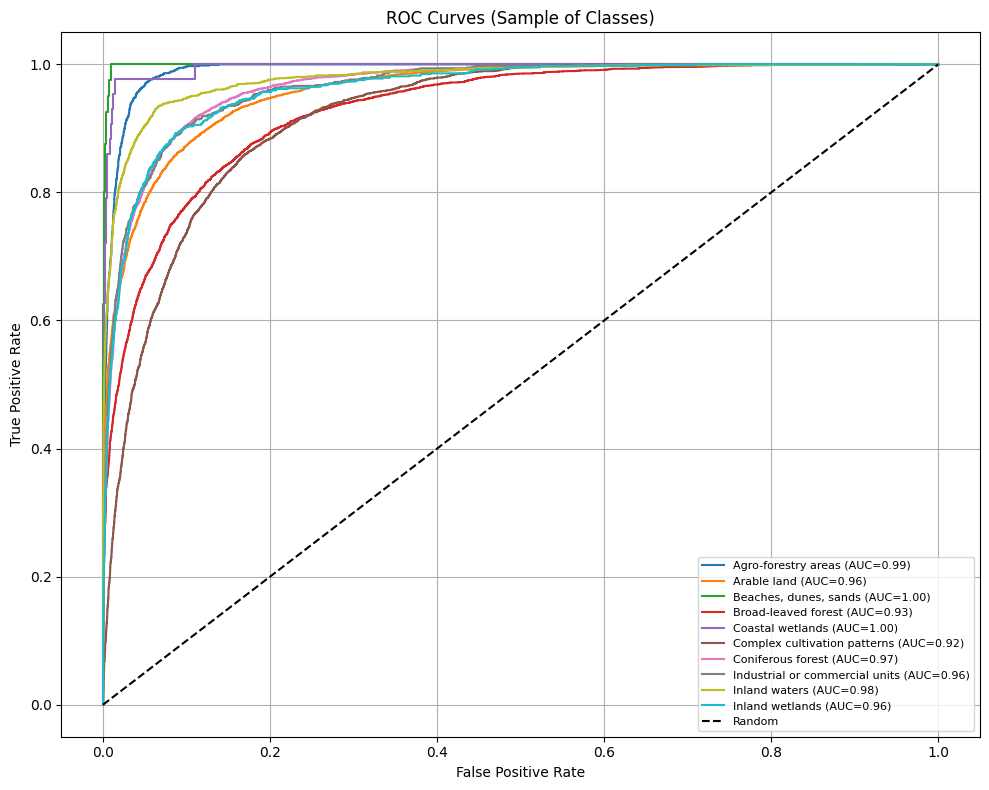

✅ Saved ROC curves in: /home/shavak_new/victor/mp2/roc_curves


In [14]:
def plot_per_class_roc(y_true, y_pred, label_names, output_dir=HOME_DIR+"/roc_curves", max_classes_to_plot=10):
    os.makedirs(output_dir, exist_ok=True)
    n_classes = y_true.shape[1]

    # Plot selected classes in one figure
    plt.figure(figsize=(10, 8))
    plotted = 0

    for i in range(n_classes):
        try:
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
            auc_val = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            continue  # Skip classes with no positive labels

        if np.isnan(auc_val):
            continue

        if plotted < max_classes_to_plot:
            plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC={auc_val:.2f})")
            plotted += 1

        # Save each ROC curve individually
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {label_names[i]}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"roc_{label_names[i].replace(' ', '_')}.png"))
        plt.close()

    # Combined figure for top classes
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Sample of Classes)")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "roc_combined.png"))
    plt.show()

    print(f"✅ Saved ROC curves in: {output_dir}")
plot_per_class_roc(y_true, y_pred, label_names)


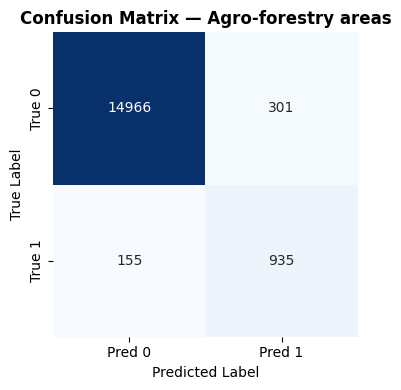

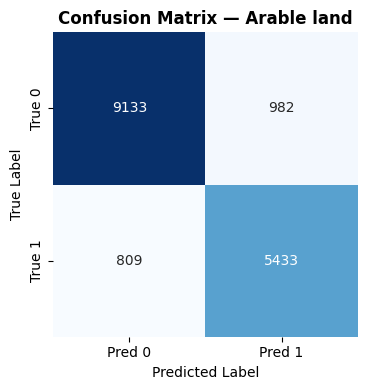

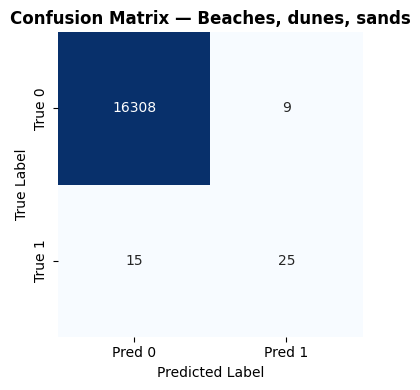

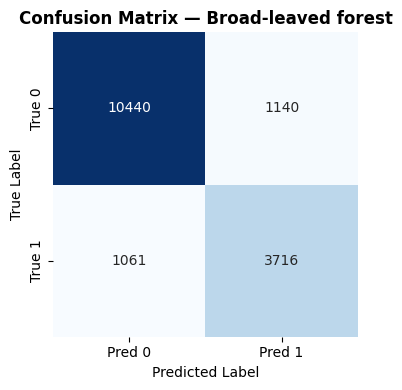

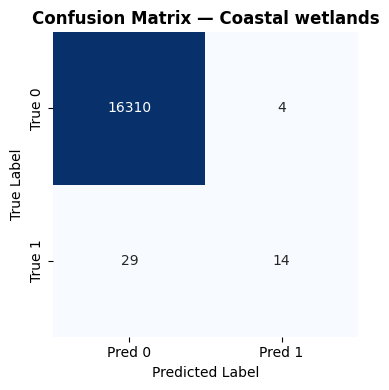

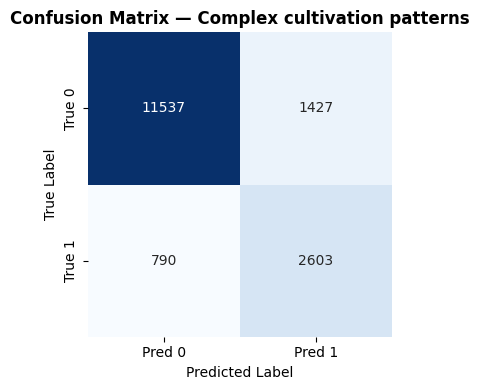

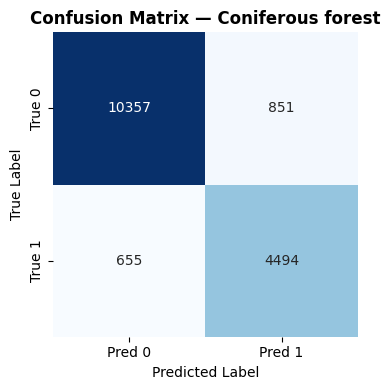

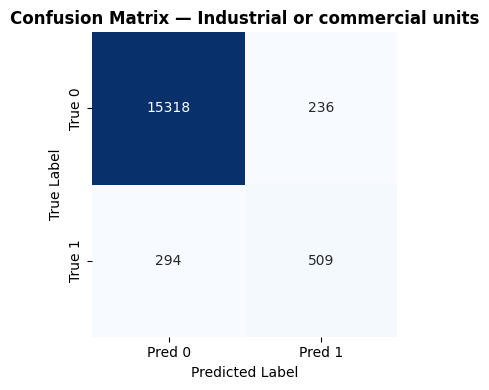

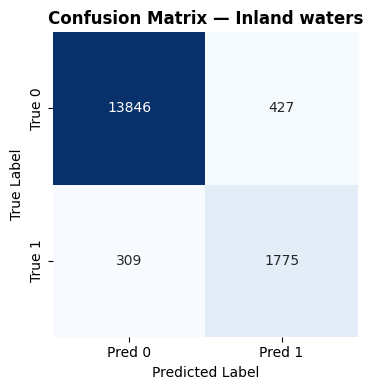

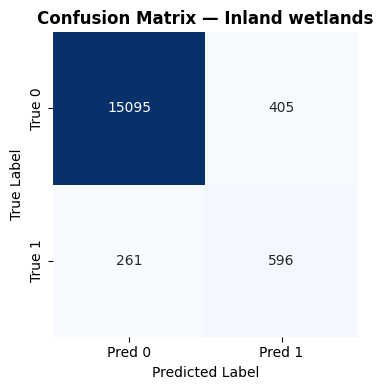

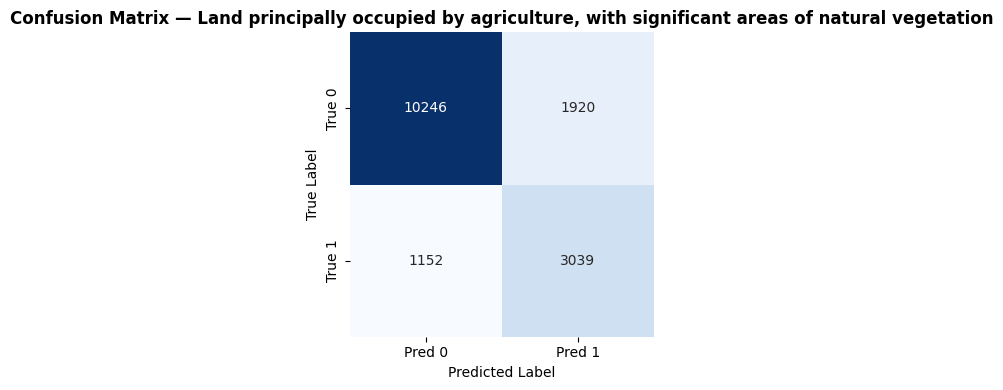

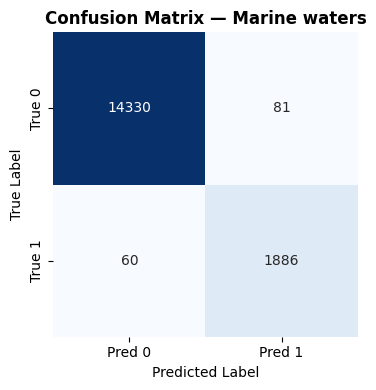

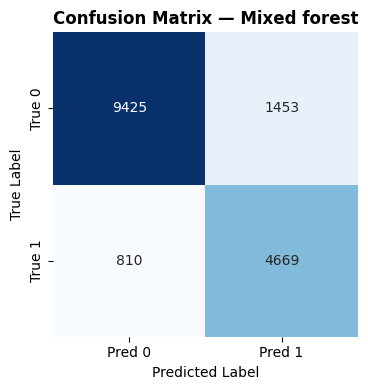

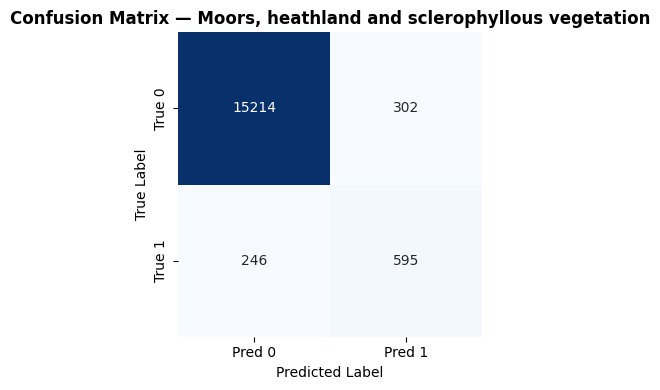

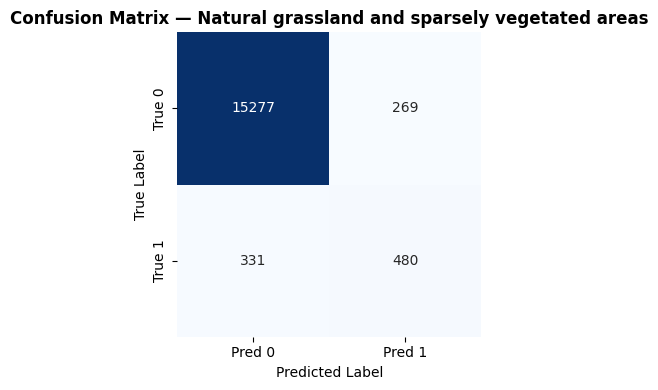

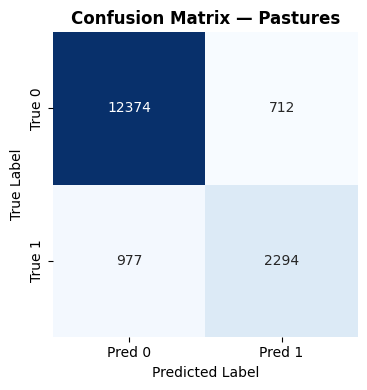

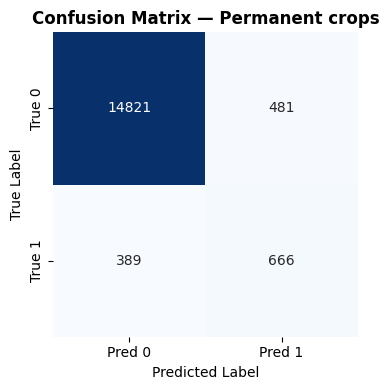

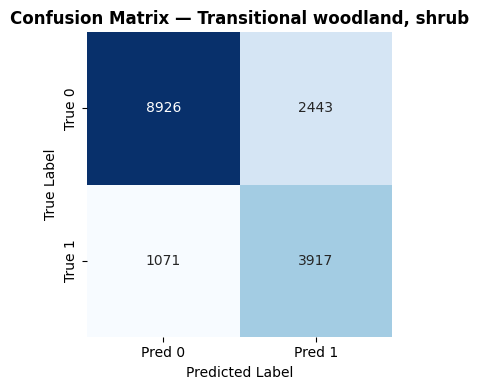

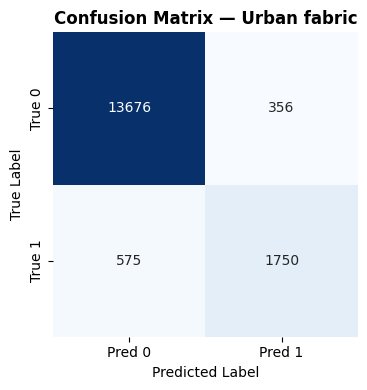

In [15]:
y_pred_bin = (y_pred >= test_thresholds).astype(int)
plot_confusion_per_class(y_true, y_pred_bin, label_names)

In [16]:
y_pred_bin = (y_pred >= test_thresholds).astype(int)
metrics_df = compute_per_class_metrics(y_true, y_pred_bin, label_names)

print("\n📊 Per-Class Metrics")
print(metrics_df.to_string(index=False, float_format="%.4f"))


📊 Per-Class Metrics
        Class  Precision  Recall     F1  Accuracy
Agro-forestr…     0.7565  0.8578 0.8040    0.9721
  Arable land     0.8469  0.8704 0.8585    0.8905
Beaches, dun…     0.7353  0.6250 0.6757    0.9985
Broad-leaved…     0.7652  0.7779 0.7715    0.8654
Coastal wetl…     0.7778  0.3256 0.4590    0.9980
Complex cult…     0.6459  0.7672 0.7013    0.8645
Coniferous f…     0.8408  0.8728 0.8565    0.9079
Industrial o…     0.6832  0.6339 0.6576    0.9676
Inland water…     0.8061  0.8517 0.8283    0.9550
Inland wetla…     0.5954  0.6954 0.6416    0.9593
Land princip…     0.6128  0.7251 0.6643    0.8122
Marine water…     0.9588  0.9692 0.9640    0.9914
 Mixed forest     0.7627  0.8522 0.8049    0.8616
Moors, heath…     0.6633  0.7075 0.6847    0.9665
Natural gras…     0.6409  0.5919 0.6154    0.9633
     Pastures     0.7631  0.7013 0.7309    0.8967
Permanent cr…     0.5806  0.6313 0.6049    0.9468
Transitional…     0.6159  0.7853 0.6903    0.7852
 Urban fabric     0.8310  0.7